## Grupo:
## Andrea Blatter, Fernanda Pucheta, Cesar Zamboni

In [ ]:
#!pip install xgboost
#!pip install seaborn 
#!pip install matplotlib

In [33]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings(action="ignore")
from datetime import datetime

In [2]:
### Loading Data
data = pd.read_csv('data/base_tarjeta_credito.csv')


## Preparamos el tag y el dataset completo

In [3]:
data.head()

,Unnamed: 0,email,cliente,FechaSaldos,periodo_cli,periodo,cant_productos,cant_PF,cant_TC,cant_PP,...,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,target,target2
0,0,cliente@mail.com,0,2019-12-06 09:45:00,24240,24240,2,0,0,0,...,0,9440.56,0.00,0.0,0,4577.00,0,NaN,0.0,0.0
1,1,cliente@mail.com,1,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,5029.59,0.00,0.0,0,8813.89,0,NaN,0.0,0.0
2,2,cliente@mail.com,2,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,50156.32,0.00,0.0,0,10387.20,0,0.0,0.0,0.0
3,3,cliente@mail.com,3,2019-12-06 09:45:00,24240,24240,6,0,3,0,...,0,26082.85,0.00,0.0,0,600.00,0,1.0,0.0,0.0
4,4,cliente@mail.com,4,2019-12-06 09:45:00,24240,24240,6,1,2,0,...,0,103080.40,470.04,0.0,0,1618.19,0,0.0,0.0,1.0


In [4]:
data.columns

Index(['Unnamed: 0', 'email', 'cliente', 'FechaSaldos', 'periodo_cli',
       'periodo', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'TipoCuentaAcredHab',
       'CategoriaProducto', 'FechaVinculacion', 'cuotas_faltantes_1',
       'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target', 'target2'],
      dtype='object')

In [5]:
data['CategoriaProducto']

0         JUB00021
1         JUB00021
2         JUB00021
3         JUB00021
4         K  00021
            ...   
494882    PRI00001
494883    PRI00001
494884    PRI00001
494885    PRI00001
494886    CON00001
Name: CategoriaProducto, Length: 494887, dtype: object

In [6]:
data['target'].value_counts()

0.0    491817
1.0      3070
Name: target, dtype: int64

In [7]:
data['target2'].value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [8]:
data[data['target']==0.0]['target2'].value_counts()

0.0    318543
1.0    173274
Name: target2, dtype: int64

In [9]:
data[data['target']==1.0]['target2'].value_counts()

1.0    3070
Name: target2, dtype: int64

In [10]:
data[data['cant_TC']==0]['target'].value_counts()

0.0    99056
1.0     1196
Name: target, dtype: int64

In [11]:
#veremos el tamaño del dataset
data.shape

(494887, 44)

In [12]:
#chequeamos columnas con valores unicos 
data.nunique()


Unnamed: 0                       247789
email                                 1
cliente                          247789
FechaSaldos                           3
periodo_cli                           3
periodo                               3
cant_productos                       58
cant_PF                              44
cant_TC                              25
cant_PP                               6
FechaUltMovCA                       971
cant_seguros                         18
importe_consumos                    317
Edad                                115
Sexo                                  3
SaldoPromedioCAPesos             411491
SaldoPromedioCADolares            63559
SaldoPromedioCCAcreedor           11063
TotalConsumoTD                   187122
TipoCuentaAcredHab                    1
CategoriaProducto                    28
FechaVinculacion                   5134
cuotas_faltantes_1                  271
cant_PF_ant_1                        43
cant_TC_ant_1                        25


## Análisis y transformación de datos

### Eliminamos columnas que no aportan nada

In [13]:
#tenemos columnas con un unico valor para todos los registros, a estas las eliminaremos porque no aportan valor
[x for x in data.columns if data[x].nunique()==1]

['email', 'TipoCuentaAcredHab']

In [14]:
#las columnas cliente y unnamed tampoco aportan nada asi que la eliminamos tmb
to_remove = ['cliente' , 'Unnamed: 0'] + [x for x in data.columns if data[x].nunique()==1]

In [15]:
#eliminamos entonces estas columnas
data.drop(columns=to_remove,inplace=True)

### Chequeamos duplicados

In [16]:
data.duplicated().any() # chequeamos si hay duplicados de registros, si hay los borramos con drop_duplicates()

True

In [17]:
data.shape

(494887, 40)

### Chequeamos faltantes

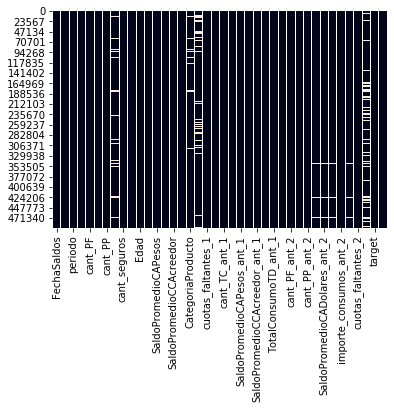

In [18]:
#haremos un heatmap para ver nulos 
sns.heatmap(data[data.columns[0:45]].isnull(), cbar=False)

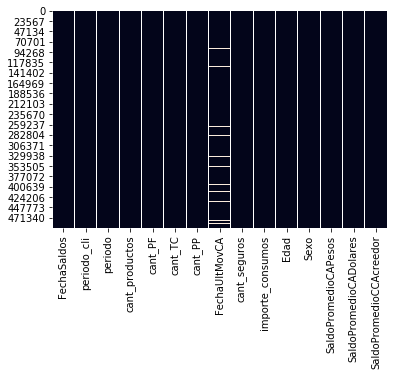

In [19]:
#no se visualiza bien asi que haremos heatmaps incluyendo menos columnas para analizar mejor 
sns.heatmap(data[data.columns[0:15]].isnull(), cbar=False)

Vemos muchos nulos en FechaUltMovCA

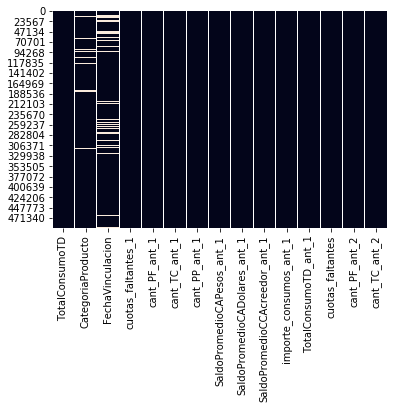

In [20]:
sns.heatmap(data[data.columns[15:30]].isnull(), cbar=False)

fecha vinculacion tiene muchos nulos tambien, la trabajaremos mas adelante

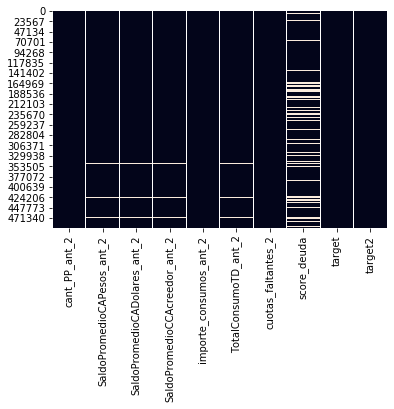

In [21]:
sns.heatmap(data[data.columns[30:45]].isnull(), cbar=False)

score deuda tiene muchos nulos tambien pero sabemos que equivalen a no tener deuda

vemos otros nulos en otras 4 columnas que son igual para todos los registros 

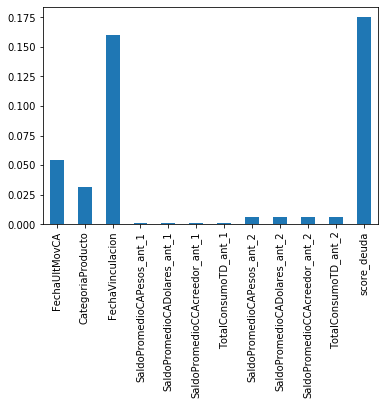

In [22]:
#contaremos la cantidad de nulos para cada columna 
nullcount = {col:data[col].isnull().sum() for col in data.columns}
#y haremos una serie con estos valores para graficarlo como grafico de barras
missing = pd.Series(nullcount)
#ahora graficamos valores relativos solamente de las variables que contienen nulos, por eso usamos div
missing[missing>0].div(data.shape[0]).plot.bar()

#### Fecha de vinculacion

In [23]:
data['FechaVinculacion'].dtype

dtype('O')

In [24]:
#lo primero que haremos sera convertirla a formato date
data['Date'] = pd.to_datetime(data['FechaVinculacion'])

In [26]:
#veremos cuanta relacion tiene fechaVinculacion con el target2 para saber si conviene eliminar los registros con valores
#nulos o reemplazarlos
data[data.FechaVinculacion.isna()]['target2'].value_counts()

0.0    46403
1.0    32861
Name: target2, dtype: int64

In [27]:
data.target2.value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [34]:
#veo que una gran cantidad tiene 1s, y como ya tenemos pocos 1s en el dataset decidiremos transformar estas fechas
#lo que haremos sera calcular la antiguedad de cada cliente usando la fecha de vinculacion
data['antiguedad']=(data.Date.dt.year - datetime.now().year)*-1

In [35]:
#entonces ahora puedo calcular la antiguedad promedio y asignar esos valores para los clientes con valores nulos 
data.loc[data['antiguedad'].isna(),'antiguedad']=data.antiguedad.mean()

In [36]:
#entonces elimino la fecha de vinculacion y conservo antiguedad
data.drop(columns='FechaVinculacion',inplace=True)

In [37]:
#borramos tmb la columna date que creamos para trabajar de manera temporal
data.drop(columns='Date',inplace=True)

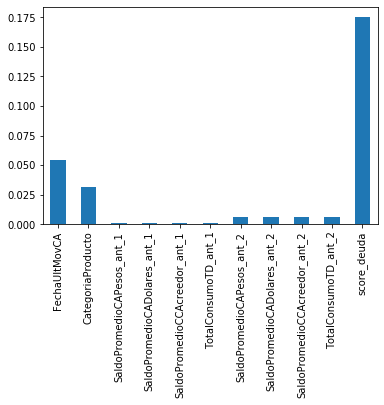

In [38]:
#vamos a volver a ver los valores nulos como quedaron 
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

#### Score deuda

In [39]:
#los valores nulos que vemos en score_deuda es lo mismo que decir que el cliente no posea deudas
#asi que a los nulos los pasaremos a 1 , y a los valores que sean 0 tambien los pasaremos a 1 
data.loc[data['score_deuda'].isnull(),'score_deuda']=1

In [40]:
data.loc[data['score_deuda']==0,'score_deuda']=1

#### Fecha ultimo movimiento

In [41]:
#ahora vamos a trabajar con fecha ultimo movimiento, primero la convertimos a date time 
data.FechaUltMovCA = pd.to_datetime(data.FechaUltMovCA)

In [42]:
#y analizamos cuantos de esos nulos tiene valor 1 en target2
data[data.FechaUltMovCA.isna()]['target2'].value_counts()

0.0    15337
1.0    11386
Name: target2, dtype: int64

In [43]:
data.target2.value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [44]:
#como hay una gran cantidad de 1s los trabajaremos enm lugar de eliminarlos
data.FechaUltMovCA.mode() #veo la moda

0   2019-12-05
dtype: datetime64[ns]

In [45]:
data['FechaUltMovCA'].describe()

count                  468164
unique                    971
top       2019-12-05 00:00:00
freq                   101996
first     2004-04-19 00:00:00
last      2020-02-06 00:00:00
Name: FechaUltMovCA, dtype: object

In [46]:
#como fecha de ultimo mov podriamos elgir la moda que esta en diciembre, pero elegiremos algunos meses antes que la moda
#y reemplazamos
data.loc[data.FechaUltMovCA.isna(),'FechaUltMovCA']=pd.to_datetime('2019-10-30')

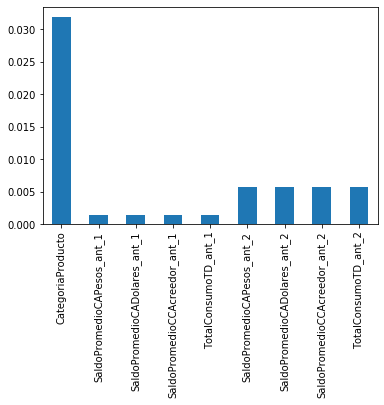

In [47]:
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

#### Categoria de producto

In [49]:
#trabajaremos ahora con categoria de producto
data.CategoriaProducto.value_counts(normalize=True, dropna=False)

K  00021    0.517437
GRL00003    0.208884
JUB00021    0.177483
NaN         0.031868
PC200003    0.020118
PC100003    0.015377
CCL00003    0.007640
L  00021    0.004710
GRA00001    0.002942
SUB00003    0.002762
WEB00003    0.002754
PRI00001    0.002750
DNI00003    0.001473
LIB00003    0.001113
CON00001    0.000705
PRI00018    0.000430
K  00001    0.000309
RED00003    0.000299
PC300003    0.000293
PC100001    0.000228
COF00001    0.000133
JOV00003    0.000109
ADO00003    0.000079
COE00001    0.000034
Q  00003    0.000024
FIU00003    0.000016
BSU00003    0.000012
PIG00003    0.000010
ACT00001    0.000004
Name: CategoriaProducto, dtype: float64

In [51]:
#vemos que mas del 80% de los datos se distribuyen entre las primeras 3 categorias
#lo que haremos entonces sera crear una categoria OTROS y asignar el resto de categorias ahi , incluyendo los nulos

#conservamos las primeras 3 categorias
to_keep = data.CategoriaProducto.value_counts(normalize=True, dropna=False)[:3].index

In [52]:
#a los nulos le asignamos la categoria otros
data.CategoriaProducto.fillna('OTROS',inplace=True)

In [53]:
#y a todos los que no pertenezcan a las primeras 3 categorias lo asignamos en la categoria otros
data.CategoriaProducto = data.CategoriaProducto.apply(lambda x:'OTROS' if x not in to_keep else x)

In [54]:
data.CategoriaProducto.value_counts()

K  00021    256073
GRL00003    103374
JUB00021     87834
OTROS        47606
Name: CategoriaProducto, dtype: int64

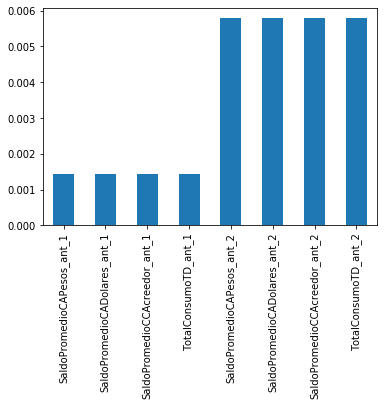

In [55]:
#vemos que columnas quedan con valores nulos
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

#### Saldos promedios y consumos totales

In [56]:
'''
todos los valores nulos que vemos en estas columnas 
'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2'
consideraremos que equivale a que tengan 0 pesos de saldo promedio o total de consumo y asi los reemplazaremos 
'''

data.fillna(0,inplace=True)

In [58]:
#veremos como queda el dataset
data.shape

(494887, 40)

### Otras transformaciones

In [59]:
data['target'].value_counts(normalize=True,dropna=False)

0.0    0.993797
1.0    0.006203
Name: target, dtype: float64

In [60]:
data['target2'].value_counts(normalize=True,dropna=False)

0.0    0.643668
1.0    0.356332
Name: target2, dtype: float64

Como tenemos muchos mas 1s en target2 que en target podemos deducir que la columna de target2 es la que refiere a si el cliente abrio o no el mail y el target a si efectivamente quiso la tarjeta

In [61]:
#no tenemos informacion suficiente en target como para trabajar con ella, por lo que la eliminamos 
data.drop(columns='target',inplace=True)

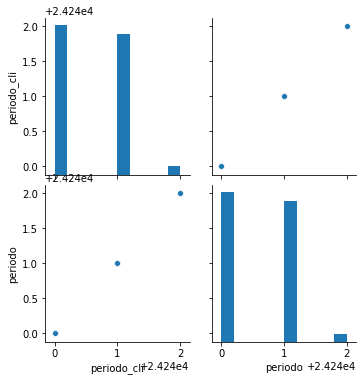

In [62]:
#Comparacion entre  periodo_cli y  periodo
for_pairplot= data[["periodo_cli", "periodo"]]
for_pairplot=for_pairplot.sample(1000)
sns.pairplot(for_pairplot)

In [63]:
#vemos que son exactamente iguales estas columnas por lo que eliminamos una de ellas 
data.drop(columns="periodo_cli", inplace=True)

### Analizaremos valores erróneos

In [64]:
data.columns

Index(['FechaSaldos', 'periodo', 'cant_productos', 'cant_PF', 'cant_TC',
       'cant_PP', 'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad',
       'Sexo', 'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'CategoriaProducto',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad'],
      dtype='object')

In [65]:
data['FechaSaldos'].value_counts()
#vemos solo 3 fecha de saldos.. sera una fecha de corte? 

2019-12-06 09:45:00    247789
2020-01-08 09:48:00    233084
2020-02-07 14:13:00     14014
Name: FechaSaldos, dtype: int64

In [66]:
data['periodo'].value_counts()

24240    247789
24241    233084
24242     14014
Name: periodo, dtype: int64

In [67]:
#tambien solo hay 3 tipos de periodos, igual que para fecha de saldos. de estas 2 podemos quedarnos solo con una columna
#en tal caso preferiria quedarme con la columna que indica la fecha de saldos ya que posee mas informacion que el nro del periodo
data.drop(columns="periodo", inplace=True)

In [68]:
data['cant_productos'].value_counts()
#vemos que sin duda tenemos valores outliers en esta columna y de la misma manera podemos tener en cant_PF, cant_TC, cant_PP etc

3      127925
2      110198
4       95671
5       53563
1       52476
6       26919
7       13576
8        6690
9        3421
10       1872
11       1007
12        536
13        366
14        200
15        104
16         78
17         64
0          32
20         27
18         24
19         17
21         13
22         11
26         10
23          9
25          7
103         6
27          6
24          5
101         4
106         4
30          4
29          3
104         3
41          3
46          3
107         2
49          2
102         2
36          2
100         2
38          2
53          2
47          2
105         1
93          1
77          1
55          1
45          1
31          1
43          1
42          1
39          1
37          1
34          1
33          1
32          1
213         1
Name: cant_productos, dtype: int64

In [69]:
data['Edad'].value_counts()

39     12625
37     12538
40     12501
38     12491
35     12449
       ...  
106        4
117        2
114        2
113        2
111        2
Name: Edad, Length: 115, dtype: int64

In [70]:
#vemos que hay muchas edades que estan por encima de los 100, no tienen sentido asi que las reemplazaremos por la edad promedio
data['Edad'].describe()

count    494887.000000
mean         49.156480
std          17.378098
min           0.000000
25%          36.000000
50%          46.000000
75%          61.000000
max         119.000000
Name: Edad, dtype: float64

In [71]:
data.loc[data['Edad']>=100,'Edad']=47

In [72]:
#haremos lo mismo para los que tengan menos de 18 años 
data.loc[data['Edad']<18,'Edad']=47

In [73]:
data['Edad'].describe()
#nos queda asi la edad minima de 18 años y la maxima de 99, tiene mas sentido de esta forma.. 

count    494887.000000
mean         49.237800
std          17.120545
min          18.000000
25%          36.000000
50%          46.000000
75%          61.000000
max          99.000000
Name: Edad, dtype: float64

In [74]:
data['Sexo'].value_counts()

F    277632
M    215313
       1942
Name: Sexo, dtype: int64

In [75]:
#tenemos muchos valores con string vacio, podemos considerar que se refiere a una cuenta 
#de tipo juridica y por eso no tiene sexo y asignarle el valor "ju"
data.loc[data['Sexo']==" ",'Sexo']="JU"

In [76]:
data['Sexo'].value_counts()

F     277632
M     215313
JU      1942
Name: Sexo, dtype: int64

### Corrección de valores outliers

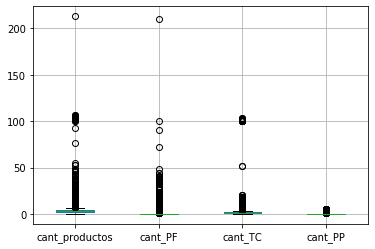

In [77]:
#Analizaremos las variables cant_productos, cant_PF, cant_TC y cant_PP en busca de valores outliers
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

In [78]:
#vemos que para cant_PP no tenemos valores outliers pero para las otras 3 columnas si, entonces los eliminaremos
data.loc[data['cant_productos']>data['cant_productos'].quantile(0.99),'cant_productos'] = data['cant_productos'].quantile(0.99)

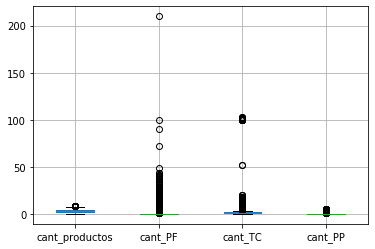

In [79]:
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

In [80]:
data.loc[data['cant_PF']>data['cant_PF'].quantile(0.99),'cant_PF'] = data['cant_PF'].quantile(0.99)

In [81]:
data.loc[data['cant_TC']>data['cant_TC'].quantile(0.99),'cant_TC'] = data['cant_TC'].quantile(0.99)

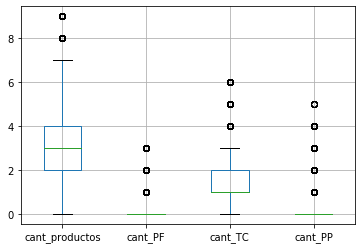

In [82]:
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

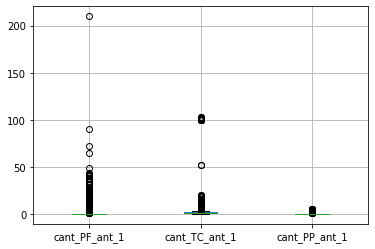

In [83]:
#realizaremos el mismo analisis para cantidades de ant 1 y eliminaremos outliers
data.boxplot(['cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1'])

In [84]:
data.loc[data['cant_PF_ant_1']>data['cant_PF_ant_1'].quantile(0.99),'cant_PF_ant_1'] = data['cant_PF_ant_1'].quantile(0.99)

In [85]:
data.loc[data['cant_TC_ant_1']>data['cant_TC_ant_1'].quantile(0.99),'cant_TC_ant_1'] = data['cant_TC_ant_1'].quantile(0.99)

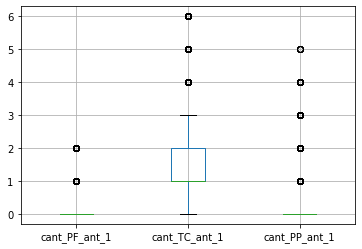

In [86]:
data.boxplot(['cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1'])

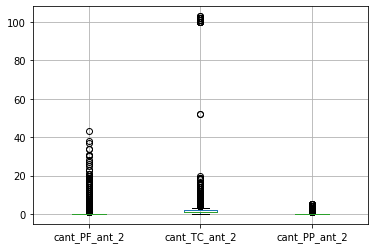

In [87]:
#por ultimo haremos el mismo analisis para las cantidades de ant 2
data.boxplot(['cant_PF_ant_2', 'cant_TC_ant_2', 'cant_PP_ant_2'])

In [88]:
#en este caso eliminaremos solo la cantidad de tarjetas de creditos y no la cantidad de plazos fijos pq sino nos quedariamos con poca info
data.loc[data['cant_TC_ant_2']>data['cant_TC_ant_2'].quantile(0.99),'cant_TC_ant_2'] = data['cant_TC_ant_2'].quantile(0.99)

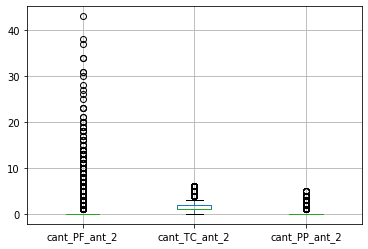

In [89]:
data.boxplot(['cant_PF_ant_2', 'cant_TC_ant_2', 'cant_PP_ant_2'])

In [90]:
data.shape

(494887, 37)

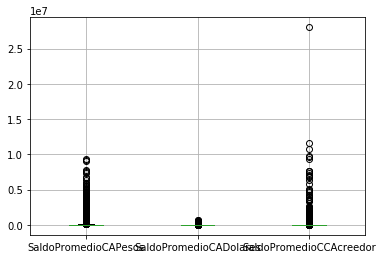

In [91]:
#Ahora realizaremos el mismo analisis para los saldos promedios
data.boxplot(['SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor'])

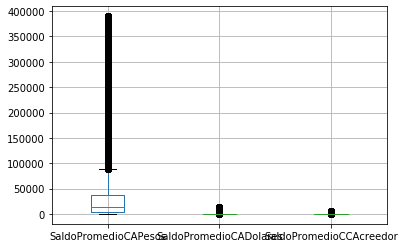

In [92]:
#Eliminaremos outliers para las 3 columnas
data.loc[data['SaldoPromedioCAPesos']>data['SaldoPromedioCAPesos'].quantile(0.99),'SaldoPromedioCAPesos'] = data['SaldoPromedioCAPesos'].quantile(0.99)
data.loc[data['SaldoPromedioCCAcreedor']>data['SaldoPromedioCCAcreedor'].quantile(0.99),'SaldoPromedioCCAcreedor'] = data['SaldoPromedioCCAcreedor'].quantile(0.99)
data.loc[data['SaldoPromedioCADolares']>data['SaldoPromedioCADolares'].quantile(0.99),'SaldoPromedioCADolares'] = data['SaldoPromedioCADolares'].quantile(0.99)
data.boxplot(['SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor'])

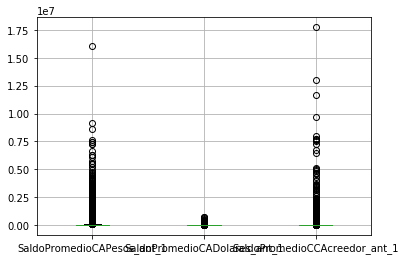

In [93]:
#haremos el mismo analisis para los saldos promedios de los meses ant1 y ant2 
data.boxplot(['SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCCAcreedor_ant_1'])

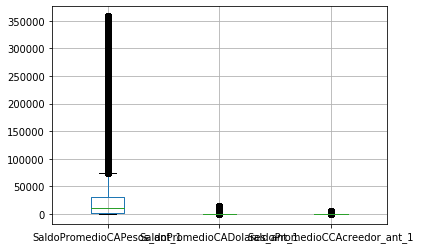

In [94]:
#Eliminaremos outliers para los 3 campos 
data.loc[data['SaldoPromedioCAPesos_ant_1']>data['SaldoPromedioCAPesos_ant_1'].quantile(0.99),'SaldoPromedioCAPesos_ant_1'] = data['SaldoPromedioCAPesos_ant_1'].quantile(0.99)
data.loc[data['SaldoPromedioCCAcreedor_ant_1']>data['SaldoPromedioCCAcreedor_ant_1'].quantile(0.99),'SaldoPromedioCCAcreedor_ant_1'] = data['SaldoPromedioCCAcreedor_ant_1'].quantile(0.99)
data.loc[data['SaldoPromedioCADolares_ant_1']>data['SaldoPromedioCADolares_ant_1'].quantile(0.99),'SaldoPromedioCADolares_ant_1'] = data['SaldoPromedioCADolares_ant_1'].quantile(0.99)
data.boxplot(['SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCCAcreedor_ant_1'])

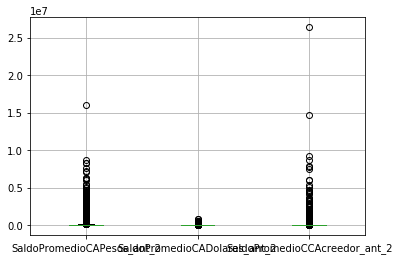

In [95]:
data.boxplot(['SaldoPromedioCAPesos_ant_2', 'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2'])

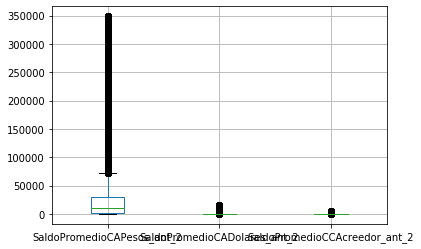

In [96]:
data.loc[data['SaldoPromedioCAPesos_ant_2']>data['SaldoPromedioCAPesos_ant_2'].quantile(0.99),'SaldoPromedioCAPesos_ant_2'] = data['SaldoPromedioCAPesos_ant_2'].quantile(0.99)
data.loc[data['SaldoPromedioCCAcreedor_ant_2']>data['SaldoPromedioCCAcreedor_ant_2'].quantile(0.99),'SaldoPromedioCCAcreedor_ant_2'] = data['SaldoPromedioCCAcreedor_ant_2'].quantile(0.99)
data.loc[data['SaldoPromedioCADolares_ant_2']>data['SaldoPromedioCADolares_ant_2'].quantile(0.99),'SaldoPromedioCADolares_ant_2'] = data['SaldoPromedioCADolares_ant_2'].quantile(0.99)
data.boxplot(['SaldoPromedioCAPesos_ant_2', 'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2'])

In [97]:
data.shape

(494887, 37)

## Estudio de distribución bivariada

### En este apartado buscaremos si existe correlación entre variable y/o contra el target

Text(0.5, 1, 'Saldos promedios \nCorrelation Heatmap')

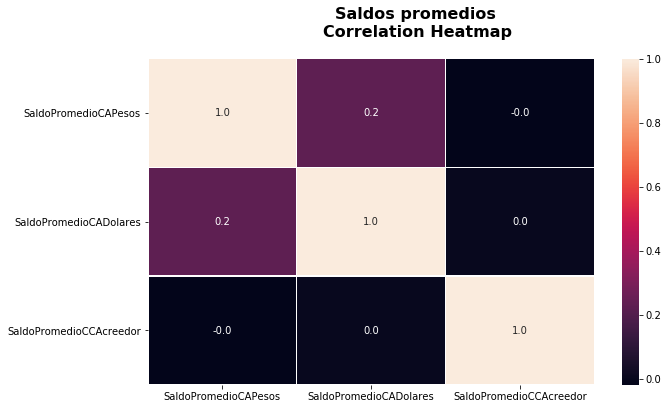

In [98]:
#Comparacion entre saldos promedios 'SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCAPesos','SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)


Text(0.5, 1, 'Saldos promedios CA Pesos \nCorrelation Heatmap')

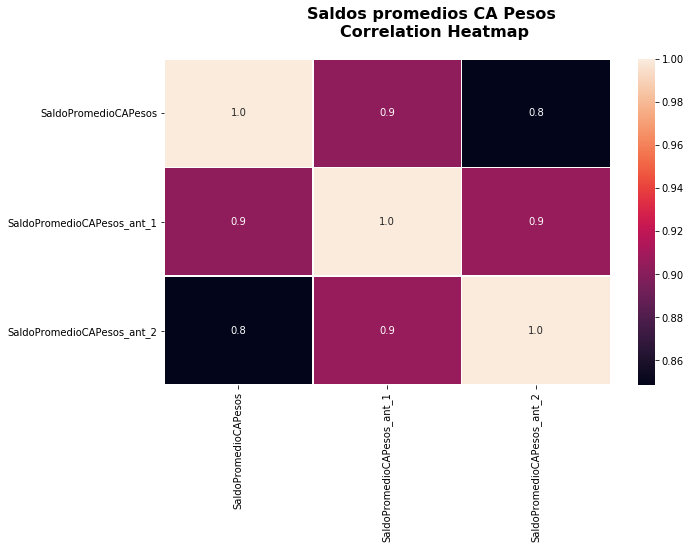

In [99]:
#Comparacion entre saldos promedios 'SaldoPromedioCAPesos', 'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCAPesos_ant_2'

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCAPesos', 'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCAPesos_ant_2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios CA Pesos \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

In [100]:
#vemos que hay una alta correlacion entre estas columnas, por lo que podriamos ver si los trabajamos por separado o agrupamos

Text(0.5, 1, 'Saldos promedios CA Dolares \nCorrelation Heatmap')

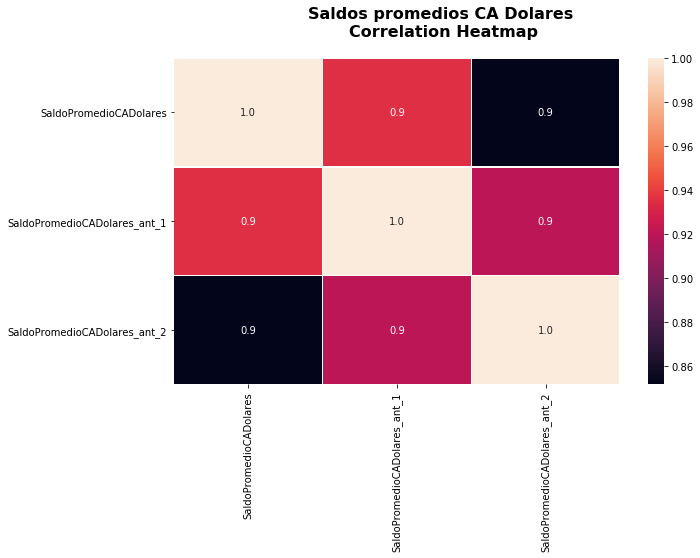

In [101]:
#Comparacion entre saldos promedios 'SaldoPromedioCADolares', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCADolares_ant_2'

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCADolares', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCADolares_ant_2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios CA Dolares \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

Text(0.5, 1, 'Saldos promedios CA Acreedor \nCorrelation Heatmap')

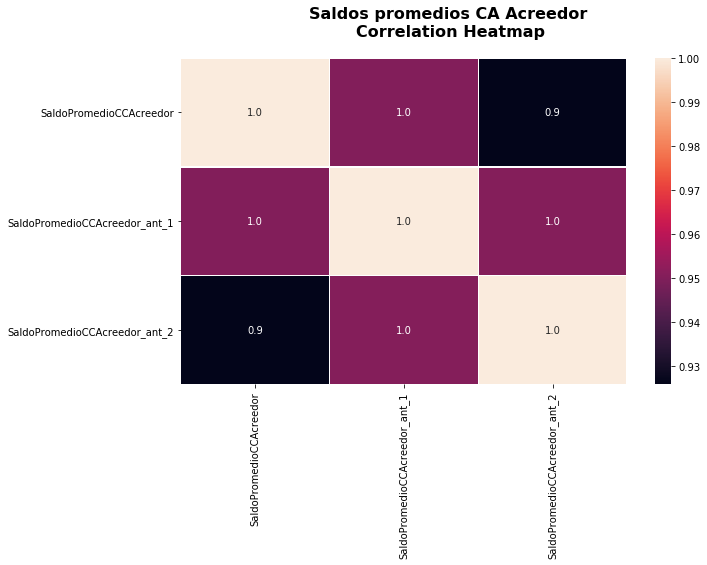

In [102]:
#Comparacion entre saldos promedios 'SaldoPromedioCCAcreedor', 'SaldoPromedioCCAcreedor_ant_1', 'SaldoPromedioCCAcreedor_ant_2'

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCCAcreedor', 'SaldoPromedioCCAcreedor_ant_1', 'SaldoPromedioCCAcreedor_ant_2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios CA Acreedor \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

In [103]:
#vemos que saldoPromedioCCAcreedor_ant_2 tiene correlacion 1 con SaldoPromedioCCAcreedor

Text(0.5, 1, 'Saldos promedios contra target \nCorrelation Heatmap')

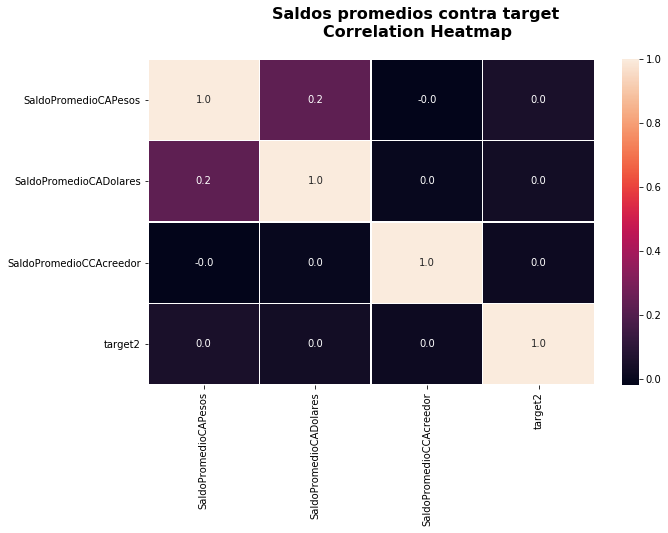

In [104]:
#Vimos que los saldos promedios no tienen correlacion entre si pero lo compararemos cpntra el target2 
#Comparacion entre saldos promedios y target 'SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'target2'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCAPesos','SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'target2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios contra target \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

In [105]:
#tienen 0 correlacion contra el target! 

Text(0.5, 1, 'Cantidad de productos contra target \nCorrelation Heatmap')

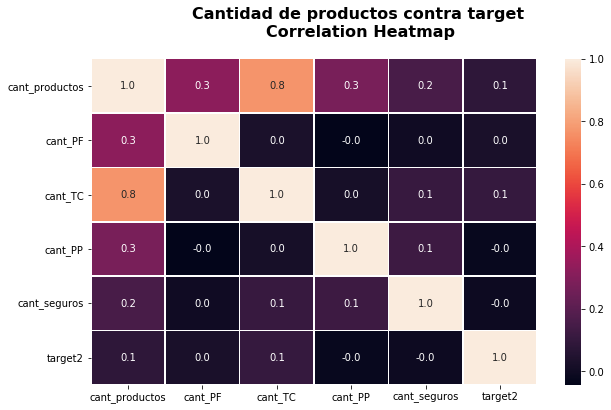

In [106]:
#Comparacion entre cantidad de productos contra target 'cant_productos', 'cant_PF','cant_TC', 'cant_PP', 'cant_seguros','target2'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['cant_productos', 'cant_PF','cant_TC', 'cant_PP', 'cant_seguros','target2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Cantidad de productos contra target \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

Text(0.5, 1, 'Cantidad de cuotas faltantes contra target \nCorrelation Heatmap')

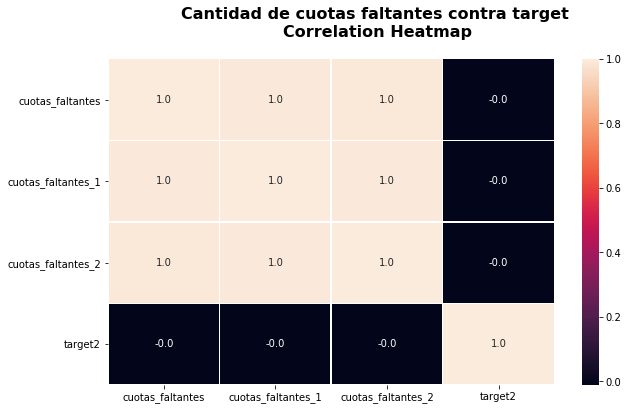

In [107]:
#Comparacion entre cuotas faltantes contra target 'cuotas_faltantes', 'cuotas_faltantes_1','cuotas_faltantes_2','target2'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['cuotas_faltantes', 'cuotas_faltantes_1','cuotas_faltantes_2','target2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Cantidad de cuotas faltantes contra target \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

## Ingeniería de variables

### Variables continuas

#### Calcular media, std, min, max, suma. Esto es por fila entre los períodos, es decir, por ejemplo, cálculo de esos datos para los montos que incluyen _1 y _2. Dejarlas como columnas adicionales.

In [108]:
#busca todos los que tienen _1
trimestrales = [x for x in data.columns if '_1' in x]

In [109]:
# aca obtegno los que tienen ant_1 ant_2 y current
trimestrales = trimestrales + [x.strip('ant_1') for x in trimestrales] + [x.replace('_1','_2') for x in trimestrales]

In [110]:
for col in data.columns:
    if col+'_ant_1' in data.columns:
        print("Calculating %s" % col)
        data[col+'_mean']=data[[col,col+'_ant_1',col+'_ant_2']].mean(axis=1)
        data[col+'_std']=data[[col,col+'_ant_1',col+'_ant_2']].std(axis=1)
        data[col+'_min']=data[[col,col+'_ant_1',col+'_ant_2']].min(axis=1)
        data[col+'_max']=data[[col,col+'_ant_1',col+'_ant_2']].max(axis=1)
        data[col+'_TasaNew']=data[col].div(data[col+'_ant_1'])
        data[col+'_TasaOld']=data[col].div(data[col+'_ant_2'])

Calculating cant_PF
Calculating cant_TC
Calculating cant_PP
Calculating importe_consumos
Calculating SaldoPromedioCAPesos
Calculating SaldoPromedioCADolares
Calculating SaldoPromedioCCAcreedor
Calculating TotalConsumoTD


Elimino los NaN e infinitos de tasas

In [111]:
data.replace([np.inf, -np.inf], np.nan)

,FechaSaldos,cant_productos,cant_PF,cant_TC,cant_PP,FechaUltMovCA,cant_seguros,importe_consumos,Edad,Sexo,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
0,2019-12-06 09:45:00,2.0,0.0,0.0,0,2019-12-02,0,0,68,M,...,0.0000,0.0000,NaN,NaN,4429.353333,1522.668249,2838.24,5872.82,0.483284,0.620109
1,2019-12-06 09:45:00,1.0,0.0,0.0,0,2019-12-04,0,0,67,F,...,0.0000,0.0000,NaN,NaN,7178.743333,1420.905397,6244.15,8813.89,0.963873,0.708444
2,2019-12-06 09:45:00,1.0,0.0,0.0,0,2019-12-05,1,0,68,F,...,0.0000,0.0000,NaN,NaN,14639.400000,3868.414530,10387.20,17950.29,0.867992,1.499991
3,2019-12-06 09:45:00,6.0,0.0,3.0,0,2019-12-05,1,0,68,F,...,0.0000,0.0000,NaN,NaN,4216.740000,3207.166958,600.00,6714.54,0.794646,8.892800
4,2019-12-06 09:45:00,6.0,1.0,2.0,0,2019-12-05,1,0,67,F,...,0.0000,0.0000,NaN,NaN,600.450000,886.133696,0.00,1618.19,NaN,0.113188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494882,2020-02-07 14:13:00,1.0,0.0,0.0,0,2020-02-06,0,0,47,JU,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,NaN,NaN
494883,2020-02-07 14:13:00,1.0,0.0,0.0,0,2019-05-22,0,0,47,JU,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,NaN,NaN
494884,2020-02-07 14:13:00,1.0,0.0,0.0,0,2019-09-27,0,0,47,JU,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,NaN,NaN
494885,2020-02-07 14:13:00,1.0,0.0,0.0,0,2020-02-06,0,0,47,JU,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,NaN,NaN


In [112]:
#fecha saldos tambien la transformaremos a datetime 
data.FechaSaldos = pd.to_datetime(data.FechaSaldos)

In [113]:
for col in data.columns: #ANDREA
    if col+'_ant_1' in data.columns:
        print("Replace NaN %s" % col)
        data[col+'_TasaNew'].fillna(0,inplace=True)
        data[col+'_TasaOld'].fillna(0,inplace=True)



Replace NaN cant_PF
Replace NaN cant_TC
Replace NaN cant_PP
Replace NaN importe_consumos
Replace NaN SaldoPromedioCAPesos
Replace NaN SaldoPromedioCADolares
Replace NaN SaldoPromedioCCAcreedor
Replace NaN TotalConsumoTD


In [114]:
data=data[~data.isin([np.nan, np.inf, -np.inf]).any(1)] 

In [115]:
data.columns

Index(['FechaSaldos', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'CategoriaProducto',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad', 'cant_PF_mean', 'cant_PF_std',
       'cant_PF_min', 'cant_PF_max', 'cant_PF_TasaNew', 'cant_PF_TasaOld',
       'cant_TC_mean', 'cant_TC_std', 'cant_TC_min', 'cant_TC_m

#### Calcular tasas o tendencias entre meses

#### Pensar si se puede hacer alguna otra relación entre las variables (siempre pensar por fila), los cocientes suelen ser buenas ideas, en algunos casos obviamente

### Variables categóricas

#### Evaluar si hay variables con categorías muy sub representadas (muy poquitas). Tratar de Generalizarlas... puede ser, por ejemplo, en categoría producto

#### Transformar variables Categóricas Nominales a matríz de unos y ceros

#### Transformar variables Categóricas Ordinales con Label Encoding

## Entrenamiento del modelo

## Trabajar con Train. Evaluar desbalance de clases, probar hacer un balance un poco más equitativo, probar llevarlo a 50-50. Ver Upsampling/Downsampling/SMOTE. Usar una o probarlas todas. SOLO EN TRAIN!

## Modelos recomendados para este tipo de problemas:
* Regresión Logística
* Random Forest
* Algoritmos de Boosting (XGBoost, LightGBM, AdaBoost, Catboost) Son todas variaciones muy similares
* KNN

In [116]:
#Nuestro tag estara dado por la columna target2, al que llamaremos y 
y = data['target2']

In [117]:
#tendremos en cuenta solo las columnas numericas
data = data.select_dtypes(include=['int64','float64'])

In [118]:
data.columns

Index(['cant_productos', 'cant_PF', 'cant_TC', 'cant_PP', 'cant_seguros',
       'importe_consumos', 'Edad', 'SaldoPromedioCAPesos',
       'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'TotalConsumoTD',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad', 'cant_PF_mean', 'cant_PF_std',
       'cant_PF_min', 'cant_PF_max', 'cant_PF_TasaNew', 'cant_PF_TasaOld',
       'cant_TC_mean', 'cant_TC_std', 'cant_TC_min', 'cant_TC_max',
       'cant_TC_TasaNew', 'cant_TC_TasaOld', 'cant_PP_mean', 'c

Ahora tenemos que crear la variable x que contendra la informacion para el entrenamiento del modelo (data)

Eliminaremos tambien la columna target2

In [119]:
columns = [col for col in data.columns if col not in ['target2']]
columns

['cant_productos',
 'cant_PF',
 'cant_TC',
 'cant_PP',
 'cant_seguros',
 'importe_consumos',
 'Edad',
 'SaldoPromedioCAPesos',
 'SaldoPromedioCADolares',
 'SaldoPromedioCCAcreedor',
 'TotalConsumoTD',
 'cuotas_faltantes_1',
 'cant_PF_ant_1',
 'cant_TC_ant_1',
 'cant_PP_ant_1',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'importe_consumos_ant_1',
 'TotalConsumoTD_ant_1',
 'cuotas_faltantes',
 'cant_PF_ant_2',
 'cant_TC_ant_2',
 'cant_PP_ant_2',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'importe_consumos_ant_2',
 'TotalConsumoTD_ant_2',
 'cuotas_faltantes_2',
 'score_deuda',
 'antiguedad',
 'cant_PF_mean',
 'cant_PF_std',
 'cant_PF_min',
 'cant_PF_max',
 'cant_PF_TasaNew',
 'cant_PF_TasaOld',
 'cant_TC_mean',
 'cant_TC_std',
 'cant_TC_min',
 'cant_TC_max',
 'cant_TC_TasaNew',
 'cant_TC_TasaOld',
 'cant_PP_mean',
 'cant_PP_std',
 'cant_PP_min',
 'cant_PP_max',
 'cant_PP_TasaNew'

In [120]:
X = data[columns]
X

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
0,2.0,0.0,0.0,0,0,0,68,6784.50,0.0,0.0000,...,0.0000,0.0000,0.000000,0.000000,4429.353333,1522.668249,2838.24,5872.82,0.483284,0.620109
1,1.0,0.0,0.0,0,0,0,67,9231.10,0.0,0.0000,...,0.0000,0.0000,0.000000,0.000000,7178.743333,1420.905397,6244.15,8813.89,0.963873,0.708444
2,1.0,0.0,0.0,0,1,0,68,47496.61,0.0,0.0000,...,0.0000,0.0000,0.000000,0.000000,14639.400000,3868.414530,10387.20,17950.29,0.867992,1.499991
3,6.0,0.0,3.0,0,1,0,68,24806.59,0.0,0.0000,...,0.0000,0.0000,0.000000,0.000000,4216.740000,3207.166958,600.00,6714.54,0.794646,8.892800
5,3.0,0.0,0.0,0,1,0,67,16614.82,0.0,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494881,1.0,0.0,0.0,0,0,0,58,0.00,0.0,5218.9032,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,0.000000,0.000000
494882,1.0,0.0,0.0,0,0,0,47,0.00,0.0,5218.9032,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,0.000000,0.000000
494883,1.0,0.0,0.0,0,0,0,47,0.00,0.0,5218.9032,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,0.000000,0.000000
494884,1.0,0.0,0.0,0,0,0,47,0.00,0.0,5218.9032,...,4481.6118,5218.9032,1.137311,1.164515,0.000000,0.000000,0.00,0.00,0.000000,0.000000


Ahora que tenemos las dos variables X e y, debemos realizar una division del dataset en un dataset de entrenamiento y uno de testeo

Usaremos el metodo Train Test Split, el cual se encarga de dividir nuestro conjunto original en un conjunto de entrenamiento y un conjunto de testeo

In [121]:
from sklearn.model_selection import train_test_split # cargamos el metodo

In [122]:
#Separamos el conjunto entrenamiento y test con el metodo train_test_split y se lo asignamos a las distintas variables
X_train, X_test, y_train, y_test = train_test_split(X,y)
#por default el conjunto se separara en 75% para el train y 25% para el test

In [123]:
X.shape

(410846, 80)

In [124]:
X_train

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
200526,1.0,0.0,0.0,0,0,0,22,28566.12,0.0,0.0,...,0.0,0.0,0.0,0.0,17007.500000,5993.762166,10089.00,20627.85,0.984380,2.012652
372284,2.0,0.0,1.0,0,0,0,37,3749.12,0.0,0.0,...,0.0,0.0,0.0,0.0,1584.753333,1716.786312,520.00,3565.26,1.286538,0.187644
116398,3.0,0.0,1.0,0,0,0,40,1122.42,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
97787,2.0,0.0,1.0,0,0,0,44,241.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
399059,2.0,0.0,2.0,0,0,0,32,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337089,4.0,0.0,2.0,0,1,0,43,2546.65,0.0,0.0,...,0.0,0.0,0.0,0.0,110.000000,190.525589,0.00,330.00,0.000000,0.000000
204561,1.0,0.0,0.0,0,1,0,84,45501.21,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
147299,4.0,0.0,1.0,0,0,0,35,10956.00,0.0,0.0,...,0.0,0.0,0.0,0.0,5363.033333,4197.616224,2005.29,10069.14,5.021289,2.508087
458875,5.0,0.0,3.0,1,1,0,80,118883.90,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000


In [125]:
X_test

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
478232,4.0,0.0,2.0,0,0,0,38,6905.84,1.68,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
209255,2.0,0.0,0.0,0,0,0,75,62937.10,74.49,0.0,...,0.0,0.0,0.0,0.0,6915.633333,2399.003090,4183.86,8679.36,2.074486,1.100927
319552,5.0,0.0,4.0,0,0,0,48,27663.63,0.00,0.0,...,0.0,0.0,0.0,0.0,10333.396667,1122.843812,9170.56,11411.44,1.244356,1.095338
152910,3.0,0.0,1.0,1,0,0,34,8836.43,0.00,0.0,...,0.0,0.0,0.0,0.0,33462.646667,14872.569651,17467.33,46873.78,0.484573,0.372646
18614,3.0,0.0,1.0,0,0,0,63,22271.57,0.00,0.0,...,0.0,0.0,0.0,0.0,22492.570000,11472.876336,9293.51,30074.70,1.069912,3.236097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44767,3.0,0.0,2.0,0,1,0,54,6042.09,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
89142,7.0,0.0,2.0,3,1,0,45,3527.49,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
192028,2.0,0.0,1.0,0,0,0,26,5605.73,0.00,0.0,...,0.0,0.0,0.0,0.0,4688.860000,1897.093923,2590.00,6281.48,0.498547,0.412323
25667,1.0,0.0,0.0,0,1,0,60,6393.15,0.00,0.0,...,0.0,0.0,0.0,0.0,1216.883333,615.146886,766.00,1917.65,1.262402,0.504263


Podemos observar que como separamos la variable X en train y test, la suma de registros de X_train y X_test 
dara la cantidad de registros de X. En el caso de la variable y ocurriria exactamente igual.

A su vez, X_train tendra la misma cantidad de registros o filas que y_train, y X_test la misma que y_test.

### MODELO XGBOOST

In [126]:
#utilizaremos xgboost como modelo predictivo
!pip install xgboost

In [127]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#estas herramientas nos permiten calcular metricas del modelo 

In [128]:
#ahora nos quedamos con los valores de cada variable
#values pasa de serie a array
y = y.values
X = X.values

In [129]:
def train(X_train,y_train):
    """
    Función para entrenar el modelo.
    
    Parameters
    -----------
    
    X_train: pd.DataFrame
        Dataset de Train, listo para entrenar y sin tag
        
    y_train: pd.DataFrame
        Dataset de tag, es el tag correspondiente al dataset de train.
        
    Return
    ----------
    Modelo Entrenado.
    
    """
    xgb_model = xgb.XGBClassifier()
    #instanciamos el clasificador xgb
    
    print("Comienza entrenamiento del modelo XGBoost")

    xgb_model.fit(X_train, y_train)
    #el metodo fit llama al modelo matematico que entrenara el modelo 
    #xgb model ahora va a ser un modelo entrenado
    
    print("Entrenamiento finalizado\n")

    print("Haciendo las predicciones\n\n")

    #con este modelo ya entrenado llamo al metodo predict
    XGB_preds = xgb_model.predict(X_test)
    #comparo mis predicciones con el valor real que tengo guardo en y_test 
    print(classification_report(y_test, XGB_preds))
    print(confusion_matrix(y_test, XGB_preds))
    return xgb_model

In [130]:
def predict(data_to_predict, xgb_model):
    """Funcion para hacer el entrenamiento del modelo y guardarlo en un archivo .pkl

    Parameters
    -----------

    data_to_predict : pd.DataFrame
        DataFrame listo para predecir, con las mismas transformaciones que el de entrenamiento.
        
    xgb_model : xgb.XGBClassifier
        Modelo entrenado de XGBoost

    Return
    -----------
    Dataframe de 3 columnas, la identificacion del cliente, la prediccion de la clase y la probabilidad de que el cliente
    permanezca en el servicio.


    """
    print("\n\n-------------------------")
    print("Ingreso a la funcion de prediccion\n")

    XGB_preds = xgb_model.predict_proba(X)
    #si en vez de un predict proba hacemos un predict nos daria como resultado 0 y 1 directamente, redondeando
    
    return XGB_preds

In [131]:
modelo = train(X_train, y_train)

Comienza entrenamiento del modelo XGBoost
Entrenamiento finalizado

Haciendo las predicciones


              precision    recall  f1-score   support

         0.0       0.67      0.94      0.78     66823
         1.0       0.52      0.12      0.19     35889

    accuracy                           0.65    102712
   macro avg       0.59      0.53      0.49    102712
weighted avg       0.62      0.65      0.57    102712

[[62940  3883]
 [31649  4240]]


In [123]:
#vemos que la prediccion de este modelo es muy mala, muy baja, por lo cual procederemos a trabajar con otros modelos

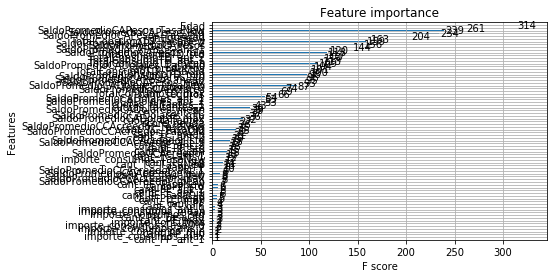

In [132]:
from xgboost import plot_importance
plot_importance(modelo, )

### Entrenamos el modelo  - MODELO DecisionTree

In [138]:
#Nuestro tag estara dado por la columna target2, al que llamaremos y 
y = data['target2']

In [139]:
#tendremos en cuenta solo las columnas numericas
data = data.select_dtypes(include=['int64','float64'])

In [140]:
columns = [col for col in data.columns if col not in ['target2']]
columns

['cant_productos',
 'cant_PF',
 'cant_TC',
 'cant_PP',
 'cant_seguros',
 'importe_consumos',
 'Edad',
 'SaldoPromedioCAPesos',
 'SaldoPromedioCADolares',
 'SaldoPromedioCCAcreedor',
 'TotalConsumoTD',
 'cuotas_faltantes_1',
 'cant_PF_ant_1',
 'cant_TC_ant_1',
 'cant_PP_ant_1',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'importe_consumos_ant_1',
 'TotalConsumoTD_ant_1',
 'cuotas_faltantes',
 'cant_PF_ant_2',
 'cant_TC_ant_2',
 'cant_PP_ant_2',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'importe_consumos_ant_2',
 'TotalConsumoTD_ant_2',
 'cuotas_faltantes_2',
 'score_deuda',
 'antiguedad',
 'cant_PF_mean',
 'cant_PF_std',
 'cant_PF_min',
 'cant_PF_max',
 'cant_PF_TasaNew',
 'cant_PF_TasaOld',
 'cant_TC_mean',
 'cant_TC_std',
 'cant_TC_min',
 'cant_TC_max',
 'cant_TC_TasaNew',
 'cant_TC_TasaOld',
 'cant_PP_mean',
 'cant_PP_std',
 'cant_PP_min',
 'cant_PP_max',
 'cant_PP_TasaNew'

In [141]:
X = data[columns]

In [142]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [143]:
X_train.shape

(308134, 80)

In [144]:
y_train.shape

(308134,)

In [145]:
X_test.shape

(102712, 80)

In [146]:
y_test.shape

(102712,)

In [147]:
from sklearn.utils import resample

In [148]:
#combine them back for resampling - upsampled
train_data = pd.concat([X_train, y_train], axis=1)# separate minority and majority classes
negative = train_data[train_data.target2==0]
positive = train_data[train_data.target2==1]# upsample minority
pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])# check new class counts
upsampled.target2.value_counts()

1.0    200739
0.0    200739
Name: target2, dtype: int64

In [149]:
X_train = upsampled.drop(columns='target2')

In [150]:
y_train = upsampled['target2']

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [152]:
tree = DecisionTreeClassifier()


In [153]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [154]:
preds = tree.predict(X_test)

In [155]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69     66661
         1.0       0.41      0.38      0.39     36051

    accuracy                           0.59    102712
   macro avg       0.54      0.54      0.54    102712
weighted avg       0.58      0.59      0.59    102712



### MODELO RandomForest - modificando parametros

In [156]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [157]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [158]:
preds=rfc.predict(X_test)

In [159]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67     66661
         1.0       0.42      0.45      0.43     36051

    accuracy                           0.59    102712
   macro avg       0.55      0.56      0.55    102712
weighted avg       0.59      0.59      0.59    102712



### MODELO RandomForest - modificando parametros

In [160]:
rfc=RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [161]:
preds=rfc.predict(X_test)

In [162]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.70      0.62      0.66     66661
         1.0       0.42      0.51      0.46     36051

    accuracy                           0.58    102712
   macro avg       0.56      0.57      0.56    102712
weighted avg       0.60      0.58      0.59    102712



### MODELO XGBClassifier y XGBRFClassifier

In [163]:
xgb_model = xgb.XGBClassifier()
xgbrf_model = xgb.XGBRFClassifier()

In [164]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [165]:
xgbrf_model.fit(X_train,y_train)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=None)

In [166]:
preds = xgb_model.predict(X_test)

In [167]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.59      0.65     66661
         1.0       0.43      0.56      0.49     36051

    accuracy                           0.58    102712
   macro avg       0.57      0.58      0.57    102712
weighted avg       0.61      0.58      0.59    102712



In [168]:
preds = xgbrf_model.predict(X_test)

In [169]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.54      0.61     66661
         1.0       0.42      0.61      0.49     36051

    accuracy                           0.56    102712
   macro avg       0.57      0.57      0.55    102712
weighted avg       0.61      0.56      0.57    102712



### MODELO KNN

In [170]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [171]:
#split dataset into train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [172]:
X_train.shape

(401478, 80)

In [173]:
X_test.shape

(102712, 80)

In [174]:
y_train.shape

(401478,)

In [175]:
y_test.shape

(102712,)

In [176]:
knn = KNeighborsClassifier(n_neighbors=30)

In [177]:
# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

In [178]:
preds = knn.predict(X_test)

In [179]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63     66661
         1.0       0.38      0.45      0.41     36051

    accuracy                           0.55    102712
   macro avg       0.52      0.52      0.52    102712
weighted avg       0.56      0.55      0.55    102712



### Hago todo lo mismo pero con downsampling


In [180]:
#Nuestro tag estara dado por la columna target2, al que llamaremos y 
y = data['target2']

In [181]:
#tendremos en cuenta solo las columnas numericas
data = data.select_dtypes(include=['int64','float64'])

In [182]:
columns = [col for col in data.columns if col not in ['target2']]
columns

['cant_productos',
 'cant_PF',
 'cant_TC',
 'cant_PP',
 'cant_seguros',
 'importe_consumos',
 'Edad',
 'SaldoPromedioCAPesos',
 'SaldoPromedioCADolares',
 'SaldoPromedioCCAcreedor',
 'TotalConsumoTD',
 'cuotas_faltantes_1',
 'cant_PF_ant_1',
 'cant_TC_ant_1',
 'cant_PP_ant_1',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'importe_consumos_ant_1',
 'TotalConsumoTD_ant_1',
 'cuotas_faltantes',
 'cant_PF_ant_2',
 'cant_TC_ant_2',
 'cant_PP_ant_2',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'importe_consumos_ant_2',
 'TotalConsumoTD_ant_2',
 'cuotas_faltantes_2',
 'score_deuda',
 'antiguedad',
 'cant_PF_mean',
 'cant_PF_std',
 'cant_PF_min',
 'cant_PF_max',
 'cant_PF_TasaNew',
 'cant_PF_TasaOld',
 'cant_TC_mean',
 'cant_TC_std',
 'cant_TC_min',
 'cant_TC_max',
 'cant_TC_TasaNew',
 'cant_TC_TasaOld',
 'cant_PP_mean',
 'cant_PP_std',
 'cant_PP_min',
 'cant_PP_max',
 'cant_PP_TasaNew'

In [183]:
X = data[columns]

In [184]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [185]:
X_train.shape

(308134, 80)

In [186]:
y_train.shape

(308134,)

In [187]:
X_test.shape

(102712, 80)

In [188]:
y_test.shape

(102712,)

In [189]:
from sklearn.utils import resample

In [190]:
#ahora lo hago con downsampling --CHEQUEAR PORQUE UPSAMPLLING Y DOWNSAMPLING DAN IGUAL? ANDREA 
train_data = pd.concat([X_train, y_train], axis=1)# separate minority and majority classes
train_data.target2.value_counts()
negative = train_data[train_data.target2==0]
positive = train_data[train_data.target2==1]# upsample minority
pos_downsampled = resample(negative,
     replace=False, # sample without replacement
     n_samples=len(positive), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
downsampled = pd.concat([pos_downsampled, positive])# check new class counts
downsampled.target2.value_counts()


1.0    107470
0.0    107470
Name: target2, dtype: int64

In [191]:
X_train = downsampled.drop(columns='target2')

In [192]:
y_train = downsampled['target2']

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [194]:
tree = DecisionTreeClassifier()


In [195]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [196]:
preds = tree.predict(X_test)

In [197]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.54      0.61     66736
         1.0       0.39      0.54      0.45     35976

    accuracy                           0.54    102712
   macro avg       0.54      0.54      0.53    102712
weighted avg       0.58      0.54      0.55    102712



### MODELO RandomForest - modificando parametros

In [198]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [199]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [200]:
preds=rfc.predict(X_test)

In [201]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68     66736
         1.0       0.42      0.45      0.43     35976

    accuracy                           0.59    102712
   macro avg       0.55      0.55      0.55    102712
weighted avg       0.59      0.59      0.59    102712



### MODELO RandomForest - modificando parametros

In [202]:
rfc=RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [203]:
preds=rfc.predict(X_test)

In [204]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.70      0.63      0.66     66736
         1.0       0.42      0.51      0.46     35976

    accuracy                           0.59    102712
   macro avg       0.56      0.57      0.56    102712
weighted avg       0.61      0.59      0.59    102712



### MODELO XGBClassifier y XGBRFClassifier

In [205]:
xgb_model = xgb.XGBClassifier()
xgbrf_model = xgb.XGBRFClassifier()

In [206]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [207]:
xgbrf_model.fit(X_train,y_train)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=None)

In [208]:
preds = xgb_model.predict(X_test)

In [209]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.57      0.64     66736
         1.0       0.43      0.59      0.49     35976

    accuracy                           0.58    102712
   macro avg       0.57      0.58      0.57    102712
weighted avg       0.62      0.58      0.59    102712



In [210]:
preds = xgbrf_model.predict(X_test)

In [211]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.71      0.62      0.66     66736
         1.0       0.43      0.53      0.48     35976

    accuracy                           0.59    102712
   macro avg       0.57      0.58      0.57    102712
weighted avg       0.61      0.59      0.60    102712



### MODELO KNN

In [212]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [213]:
knn = KNeighborsClassifier(n_neighbors=30)

In [214]:
# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

In [215]:
preds = knn.predict(X_test)

In [216]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.67      0.59      0.63     66736
         1.0       0.38      0.46      0.42     35976

    accuracy                           0.55    102712
   macro avg       0.53      0.53      0.52    102712
weighted avg       0.57      0.55      0.56    102712



### Hago todo lo mismo pero con SMOTE


In [217]:
#Nuestro tag estara dado por la columna target2, al que llamaremos y 
y = data['target2']

In [218]:
#tendremos en cuenta solo las columnas numericas
data = data.select_dtypes(include=['int64','float64'])

In [219]:
columns = [col for col in data.columns if col not in ['target2']]
columns

['cant_productos',
 'cant_PF',
 'cant_TC',
 'cant_PP',
 'cant_seguros',
 'importe_consumos',
 'Edad',
 'SaldoPromedioCAPesos',
 'SaldoPromedioCADolares',
 'SaldoPromedioCCAcreedor',
 'TotalConsumoTD',
 'cuotas_faltantes_1',
 'cant_PF_ant_1',
 'cant_TC_ant_1',
 'cant_PP_ant_1',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'importe_consumos_ant_1',
 'TotalConsumoTD_ant_1',
 'cuotas_faltantes',
 'cant_PF_ant_2',
 'cant_TC_ant_2',
 'cant_PP_ant_2',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'importe_consumos_ant_2',
 'TotalConsumoTD_ant_2',
 'cuotas_faltantes_2',
 'score_deuda',
 'antiguedad',
 'cant_PF_mean',
 'cant_PF_std',
 'cant_PF_min',
 'cant_PF_max',
 'cant_PF_TasaNew',
 'cant_PF_TasaOld',
 'cant_TC_mean',
 'cant_TC_std',
 'cant_TC_min',
 'cant_TC_max',
 'cant_TC_TasaNew',
 'cant_TC_TasaOld',
 'cant_PP_mean',
 'cant_PP_std',
 'cant_PP_min',
 'cant_PP_max',
 'cant_PP_TasaNew'

In [220]:
X = data[columns]

In [221]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [222]:
X_train.shape

(308134, 80)

In [223]:
y_train.shape

(308134,)

In [224]:
X_test.shape

(102712, 80)

In [225]:
y_test.shape

(102712,)

In [226]:
#!pip install imblearn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acceso denegado: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scikit_learn-0.22.1.dist-info\\COPYING'
Consider using the `--user` option or check the permissions.



In [428]:
#from imblearn.over_sampling import SMOTE

In [429]:
#smt = SMOTE(random_state=0)
#X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)
#smt.fit_sample(X_train, y_train)

#TODO: Error 
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

AttributeError: 'SMOTE' object has no attribute '_validate_data'

In [ ]:
print(imblearn.version)
X_res, y_res = sm.fit_sample(X, y)
#smotesample = pd.concat([X_res, y_res], axis=1)


In [353]:
X_train = downsampled.drop(columns='target2')

In [354]:
y_train = downsampled['target2']

In [355]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [356]:
tree = DecisionTreeClassifier()


In [357]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [358]:
preds = tree.predict(X_test)

In [359]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.54      0.60     53909
         1.0       0.37      0.53      0.44     27511

    accuracy                           0.54     81420
   macro avg       0.53      0.54      0.52     81420
weighted avg       0.58      0.54      0.55     81420



### MODELO RandomForest - modificando parametros

In [360]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [361]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [364]:
preds=rfc.predict(X_test)

In [365]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.70      0.65      0.68     53909
         1.0       0.40      0.47      0.43     27511

    accuracy                           0.59     81420
   macro avg       0.55      0.56      0.55     81420
weighted avg       0.60      0.59      0.59     81420



### MODELO RandomForest - modificando parametros

In [366]:
rfc=RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [367]:
preds=rfc.predict(X_test)

In [368]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.58      0.64     53909
         1.0       0.40      0.55      0.46     27511

    accuracy                           0.57     81420
   macro avg       0.56      0.56      0.55     81420
weighted avg       0.61      0.57      0.58     81420



### MODELO XGBClassifier y XGBRFClassifier

In [369]:
xgb_model = xgb.XGBClassifier()
xgbrf_model = xgb.XGBRFClassifier()

In [370]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [371]:
xgbrf_model.fit(X_train,y_train)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=1, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=1, subsample=0.8,
                tree_method=None, validate_parameters=False, verbosity=None)

In [372]:
preds = xgb_model.predict(X_test)

In [373]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.73      0.56      0.63     53909
         1.0       0.41      0.59      0.48     27511

    accuracy                           0.57     81420
   macro avg       0.57      0.57      0.56     81420
weighted avg       0.62      0.57      0.58     81420



In [374]:
preds = xgbrf_model.predict(X_test)

In [375]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.56      0.63     53909
         1.0       0.40      0.57      0.47     27511

    accuracy                           0.57     81420
   macro avg       0.56      0.57      0.55     81420
weighted avg       0.61      0.57      0.58     81420



### MODELO KNN

In [377]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [378]:
knn = KNeighborsClassifier(n_neighbors=30)

In [379]:
# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

In [380]:
preds = knn.predict(X_test)

In [381]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.68      0.59      0.63     53909
         1.0       0.36      0.45      0.40     27511

    accuracy                           0.54     81420
   macro avg       0.52      0.52      0.52     81420
weighted avg       0.57      0.54      0.55     81420

